# **Surface Crack Prediction**
This notebook focuses on  building an image classification model to automatically detect cracks in concrete surfaces using a dataset of images. The dataset contains two classes: `Positive` (images with cracks) and `Negative` (images without cracks). In this assignment we will:
1.  **Preprocessing:** Preparing the dataset by splitting, normalizing, and organizing images for training, validation, and testing.
2.  **Model Construction:** Constructing a Convolutional Neural Network (CNN) to classify the images effectively.
3.  **Performance Evaluation:** Evaluating the model's accuracy and analyzing its performance using key metrics.
4.  **Bonus Task:**  Enhancing the dataset using augmentation techniques to improve the model's robustness and generalization.

## **Step 1: Preprocess the Images**
### **1.1: Download the dataset**
We begin with retrieving the dataset from Kaggle and verify its structure. Using the `kagglehub` library, we ensure that the dataset is properly downloaded and organized. This step is crucial as all subsequent tasks depend on a clean and structured dataset. The dataset consists of two folders: `Positive` and `Negative`, each containing 20,000 images.

In [1]:
import kagglehub

# Download latest version dataset version using kagglehub
path = kagglehub.dataset_download("arunrk7/surface-crack-detection")

print("Path to dataset files:", path)

100%|██████████| 233M/233M [00:03<00:00, 79.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1


### **1.2: Organize the dataset**
To facilitate model training and evaluation, we split the dataset into training (70%), validation (20%), and test (10%) sets. Each split ensures the dataset has a balanced number of images for both classes.

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source folders
negative_dir = os.path.join(path, "Negative")
positive_dir = os.path.join(path, "Positive")

# Define target folders
base_dir = "crack_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create directories
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    os.makedirs(os.path.join(directory, "Positive"), exist_ok=True)
    os.makedirs(os.path.join(directory, "Negative"), exist_ok=True)

# Function to split data
def split_data(source, train, val, test):
    files = os.listdir(source)
    train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(source, f), os.path.join(train, f))
    for f in val_files:
        shutil.copy(os.path.join(source, f), os.path.join(val, f))
    for f in test_files:
        shutil.copy(os.path.join(source, f), os.path.join(test, f))

# Split for both classes
split_data(negative_dir, os.path.join(train_dir, "Negative"), os.path.join(val_dir, "Negative"), os.path.join(test_dir, "Negative"))
split_data(positive_dir, os.path.join(train_dir, "Positive"), os.path.join(val_dir, "Positive"), os.path.join(test_dir, "Positive"))


### **1.3: Normalize the images**
Normalizing pixel values to the range [0, 1] helps improve model training by standardizing the input values, ensuring consistency and stability during gradient updates.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image preprocessing and augmentation

# Normalize pixel values using rescaling
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(227, 227), batch_size=32, class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(227, 227), batch_size=32, class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(227, 227), batch_size=32, class_mode='binary'
)


Found 28000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


## **Step 2: Construct and Train a Convolutional Neural Network**
### **2.1: Define the CNN architecture**
 The CNN is designed to extract spatial features (using convolutional layers) and classify images (using dense layers). Dropout is used to prevent overfitting.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **2.2: Compile the model**
 The Adam optimizer adapts the learning rate, and binary cross-entropy is used for the loss function since this is a binary classification task.

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


### **2.3: Train the model**
 The model is trained for a fixed number of epochs using the training data and validated with the validation set to monitor performance.

In [6]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.9015 - loss: 0.2775 - val_accuracy: 0.9812 - val_loss: 0.0535
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/step - accuracy: 0.9814 - loss: 0.0667 - val_accuracy: 0.9892 - val_loss: 0.0305
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 61ms/step - accuracy: 0.9883 - loss: 0.0403 - val_accuracy: 0.9898 - val_loss: 0.0357
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.9902 - loss: 0.0381 - val_accuracy: 0.9882 - val_loss: 0.0361
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.9916 - loss: 0.0282 - val_accuracy: 0.9935 - val_loss: 0.0182
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.9923 - loss: 0.0305 - val_accuracy: 0.9938 - val_loss: 0.0267
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 85s 65ms/step - accuracy: 0.9937 - loss: 0.0240 - val_accuracy: 0.9927 - val_loss: 0.0249
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.9923 - loss: 0.0270 - val_accurac

## **Step 3: Calculate Performance Measures and Analyze Results**
### **3.1: Evaluate the model on the test set**
Testing the model on unseen data ensures that it generalizes well to new inputs.

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9880 - loss: 0.0523
Test Accuracy: 0.99


### **3.2: Visualize training performance**
Plotting training and validation accuracy and loss helps identify trends, such as overfitting or underfitting.

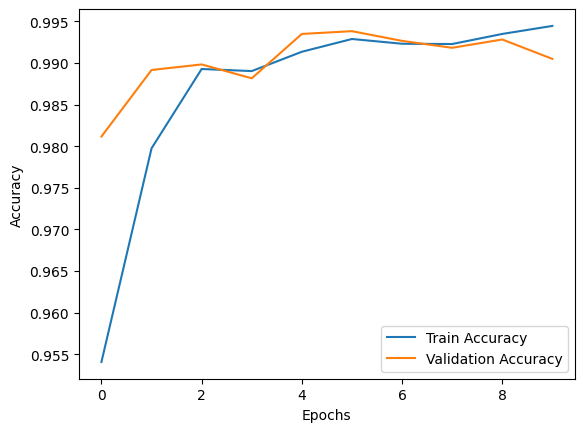

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### **3.3: Interpret results**

## **Step 4 (Bonus Task): Use Data Augmentation to Enhance Performance**
### **4.1: Augment the Data**
Augmenting data improves generalization by creating new samples using transformations like rotation, flipping, and scaling.*italicized text*

In [10]:
aug_train_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

aug_train_data = aug_train_gen.flow_from_directory(train_dir, target_size=(227, 227), batch_size=32, class_mode='binary')


Found 28000 images belonging to 2 classes.


### **4.2: Retrain with Augmented Data**
Retraining the model with augmented data tests the network's robustness and improves its performance.

In [12]:
history_aug = model.fit(aug_train_data, validation_data=val_generator, epochs=10)


Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 339s 384ms/step - accuracy: 0.9845 - loss: 0.0551 - val_accuracy: 0.9937 - val_loss: 0.0188
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 340s 385ms/step - accuracy: 0.9863 - loss: 0.0524 - val_accuracy: 0.9933 - val_loss: 0.0222
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 381s 385ms/step - accuracy: 0.9873 - loss: 0.0427 - val_accuracy: 0.9933 - val_loss: 0.0197
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 344s 390ms/step - accuracy: 0.9888 - loss: 0.0395 - val_accuracy: 0.9935 - val_loss: 0.0185
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 341s 388ms/step - accuracy: 0.9882 - loss: 0.0397 - val_accuracy: 0.9913 - val_loss: 0.0249
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 337s 383ms/step - accuracy: 0.9898 - loss: 0.0364 - val_accuracy: 0.9943 - val_loss: 0.0183
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 338s 384ms/step - accuracy: 0.9882 - loss: 0.0444 - val_accuracy: 0.9942 - val_loss: 0.0197
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 339s 384ms/step - accuracy: 0.9906 -